<a href="https://colab.research.google.com/github/GilsonFrias/ECGmonitor/blob/master/GP_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PedidosYa Google Play Reviews Exploratory Data Analysis

Author: [Gilson Frías](https://www.linkedin.com/in/gilsonfrias/)  
Oct 23 2020

This notebook contains a set of classes and methods deviced to scrap the Google Play store for customers reviews on the PedidosYa App alongside two other competitor apps. Statistical analysis is then made on the downloaded reviews set and accompanying meta data. 

**Section 1** contains two parts: A comparative analysis between differences on ratings for the three apps and a text analysis of the reviwes to identify the main topics used by the customers in their reviews.

**Section 2** contains a brief conclussion on the findings. 


To run all cells go to *`Runtime`* and click on *`Run all`*. Double click on any `[Code]` cell to inspect its contents. 

# Section 1: Exploratory Data Analysis (EDA) of Reviews text and ratings data

## 1.1 Configure Python Environment

In [ ]:
#@title `[Code]` Install Python dependencies
!pip install -q google-play-scraper
!pip install -q dash==1.16.3
!pip install -q jupyter-dash
!pip install -q dash_core_components
!pip install -q dash_html_components
!pip install -q dash_table
!pip install -q twint  

#Download nltk corpus data
!python -m nltk.downloader all 

In [2]:
#@title `[Code]` Import Python libraries

  #Text processing libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

  #Google Play reviews scrapper
from google_play_scraper import app, Sort, reviews

  #Data visualization libraries
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

  #Utilities
import sys
import warnings
warnings.filterwarnings('ignore')

In [3]:
#@title `[Code]` Construct *reviewsProcessor* class


#N_REVIEWS holds the total number of reviews to scrap
N_REVIEWS = 1000

'''
The class 'reviewsProcessor' contains an instance of google-play-scrapper, the Python 
package responsible for scrapping reviews from Google Play. 
  * get_meta() -> void :function. Gets metadata associated to a Google Play app (self.package)
  * get_reviews(N) -> void :function. Scraps N reviews for the given package (self.package)
  * package: string. The Google Play app package name
  * meta: dictionary. The Google Play app metadata info
  * reviews: dictionary. The Google Play app reviews corpus with additional info such as ratings
                          posting dates and number of thumbs up from the community.  
'''

class reviewsProcessor():
  def __init__(self, code='py'):
    self.app_dict = {
        'py':'com.pedidosya',
        'ue':'com.ubercab.eats',
        'ca':'net.enteractiva.colmapp'
    }
    self.package = self.app_dict[code] if code in list(self.app_dict.keys()) else code
    self.meta = {}
    self.reviews = {}
    self.continuation_token = object
    self.lang = 'es'
    self.region = 'do'
  
  def get_meta(self):
    try:
      self.meta = app(self.package, lang=self.lang, country=self.region)
    except:
      e = sys.exc_info()[0]
      print('[Catch Exception]::', e)

  def get_reviews(self, N=N_REVIEWS):
    self.reviews, self.continuation_token = reviews(
        self.package, lang=self.lang, country=self.region,
        sort=Sort.MOST_RELEVANT,
        count=N,
        filter_score_with=None
    )

In [4]:
#@title `[Code]` Construct *vectorizer* class
'''
The class 'vectorizer' constructs a pipeline to process a text corpus for Natural Language Processing
and statistical analysis with Python's NLTK API and sklearn.
  * prepare_text(text) -> void :function. Takes a string('text') and prepares it for proper vectorization by,
                                          removing punctuation characters and common stop words for the spanish
                                          languaje. Also, common words are reduced their primary lexical unit. 
  * vectorize(type, ngrams) -> void :function. Converts a text corpus (previously prepared and stored in self.text)
'''


class vectorizer():
  def __init__(self):
    self.cleanText = []
    self.text = []
    self.vectors = []
    self.stopWords = stopwords.words('spanish')
    self.stemmer = SnowballStemmer('spanish')
    self.vectorizer = object
    self.class_='' 
  
  #Text cleaning
  def prepare_text(self, text):
    for phrase in text:
      #1. Split text into a list of words
      tokens = word_tokenize(phrase)
      #2. Remove punctuation and convert to lowercase
      words = [word.lower() for word in tokens if word.isalpha()]
      #3. Remove stop words (i.e. ['la', 'se', 'pero', ...])
      words = [word for word in words if not word in self.stopWords]
      self.cleanText.append(words)
      #4. Reduce each word to its stem form (.i.e ['hablamos', 'hablé'] => 'habl')
      self.text.append([self.stemmer.stem(word) for word in words])

  #Text vectorization
  def vectorize(self, type_='cv', ngrams=()):
    #1. Instantiate vectorizer object Count vectorization
    if type_=='cv': #Count vectorization
      self.class_='cv'
      if ngrams:
        self.vectorizer = CountVectorizer(analyzer='word', ngram_range=ngrams)
      else:
        self.vectorizer = CountVectorizer()
    elif type_=='tfidf': #Term Frequency-Inverse Document Frequency vectorization
      self.class_='tfidf'
      self.vectorizer = TfidfVectorizer()
    else:
      self.vectorizer = None

    #2. Fit corpus for vectorization
    try:
      self.vectors = self.vectorizer.fit_transform([' '.join(txt) for txt in self.text])
    except:
      self.vectors = []

  def get_vectors(self):
    return self.vectors.toarray()


## 1.2 Download Reviews data from Google Play

In [5]:
#@title `[Code]` Download reviews and meta data

#Scrap app description meta data and the 1000 most relevant reviews
  #1. PedidosYa
py = reviewsProcessor(code='py')
py.get_meta()
py.get_reviews()

  #2. UberEats
ue = reviewsProcessor(code='ue')
ue.get_meta()
ue.get_reviews()

  #3. ColmaApp
ca = reviewsProcessor(code='ca')
ca.get_meta()
ca.get_reviews()

## 1.3 Clean text data and represent it in a numerical format through a vectorization process

In [6]:
#@title `[Code]` Order reviews data in the form of Pandas Data Fames
#Arrange reviews and metadata into Pandas Data Frame objects
pyDF = pd.DataFrame(py.reviews)
ueDF = pd.DataFrame(ue.reviews)
caDF = pd.DataFrame(ca.reviews)

#Drop innecessary columns (userName, userImage) 
pyDF = pyDF.drop(['userName', 'userImage'], axis=1)
ueDF = ueDF.drop(['userName', 'userImage'], axis=1)
caDF = caDF.drop(['userName', 'userImage'], axis=1)

In [7]:
#@title `[Code]` Vectorize text data (transform words into an ordered numerical form)
  #For each set of reviews in ['PedidosYa', 'UberEats', 'ColmaApp'] do:
#Step 1: Instantiate 'vectorizer' object
#Step 2: Pre-process text (split into words, clean punctuation, steamming)
#Step 3: vectorize pre-processed corpus
#Step 4: Conform Data Frame with resultant vectors

  #PedidosYa 
pyVectorizer1 = vectorizer()
pyVectorizer1.prepare_text(pyDF['content'])
pyVectorizer1.vectorize() 
pyVecDF1 = pd.DataFrame(pyVectorizer1.get_vectors(), columns=pyVectorizer1.vectorizer.get_feature_names())

pyVectorizer2 = vectorizer()
pyVectorizer2.prepare_text(pyDF['content'])
pyVectorizer2.vectorize(ngrams=(2,2))
pyVecDF2 = pd.DataFrame(pyVectorizer2.get_vectors(), columns=pyVectorizer2.vectorizer.get_feature_names())

pyVectorizer3 = vectorizer()
pyVectorizer3.prepare_text(pyDF['content'])
pyVectorizer3.vectorize(type_='tfidf')
pyVecDF3 = pd.DataFrame(pyVectorizer3.get_vectors(), columns=pyVectorizer3.vectorizer.get_feature_names())

_____

## 1.4 Exploratory Data Analysis: analyzing reviews and rating data for *PedidosYa* and the competition

### 1.4.1 Overal Number of reviews given oredered according to rating (*PedidosYa* vs *UberEats*)

In [8]:
#@title `[Code]` Plot overall PedidosYa vs UberEats Reviews
#Construct a comparative bar plot with the accumulated ratings data from PedidosYa and UberEats
ratings = ['One star', 'Two star', 'Three star', 'Four star', 'Five star']
colors = ['#DC3912', '#336600', '#333399', '#669999', '#993333']

fig1 = go.Figure(data=[
    go.Bar(name='PedidosYa', x=ratings, y=py.meta['histogram'], marker_color=colors[0]),
    go.Bar(name='UberEats', x=ratings, y=ue.meta['histogram'], marker_color=colors[1]),
    #go.Bar(name='ColmaApp', x=ratings, y=ca.meta['histogram'], marker_color=colors[2]),          
])

fig1.update_layout(barmode='group', 
                  title='Figure 1: Total distribution of Google Play ratings (PedidosYa vs UberEats)',
                  xaxis=dict(title='Ratings', titlefont_size=16, tickfont_size=14),
                  yaxis=dict(title='Reviews count', titlefont_size=16, tickfont_size=14)
)
fig1.show()

### <font color='Blue'>Insights:</font> *UberEats* appears to have a bigger marker share according to the overall number of reviews counts. To better appreciate how users rate both applications, a smaller pool of 1000 reviews will be considered next.   

## 1.4.2 Look at the distribution of ratings for PedidosYa and the competition for a small sample of 1000 reviews

In [9]:
#@title `[Code]` Plot review ratings count for *PedidosYa* vs *UberEats* vs *ColmApp*
#Construct a comparative bar plot with the ratings data, this time from the 1000 scrapped reviews from PedidosYa, UberEats and ColmApp
pyCounts = [pyDF.loc[pyDF['score']==n, 'score'].size for n in range(1, 6)]
ueCounts = [ueDF.loc[ueDF['score']==n, 'score'].size for n in range(1, 6)]
caCounts = [caDF.loc[caDF['score']==n, 'score'].size for n in range(1, 6)]

fig2 = go.Figure(data=[
    go.Bar(name='PedidosYa', x=ratings, y=pyCounts, marker_color=colors[0]),
    go.Bar(name='UberEats', x=ratings, y=ueCounts, marker_color=colors[1]),
    go.Bar(name='ColmApp', x=ratings, y=caCounts, marker_color=colors[2]),          
])

fig2.update_layout(barmode='group', 
                  title='Figure 2: Distribution of Google Play ratings (based on {} retrieved reviews)'.format(N_REVIEWS),
                  xaxis=dict(title='Ratings', titlefont_size=16, tickfont_size=14),
                  yaxis=dict(title='Reviews count', titlefont_size=16, tickfont_size=14)
)
fig2.show()

In [10]:
#@title `[Code]` Examine the distribution of app ratings in individual pie plots
from plotly.subplots import make_subplots
ratColors = ['#0033cc', '#993366', '#00cc00', '#cc66ff', '#ff9900']
fig3 = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]],
                     subplot_titles=['PedidosYa', 'UberEats', 'ColmApp'])
fig3.add_trace(go.Pie(labels=ratings, values=pyCounts, name='PedidosYa',marker_colors=ratColors), 1,1)
fig3.add_trace(go.Pie(labels=ratings, values=ueCounts, name='UberEats'), 1,2)
fig3.add_trace(go.Pie(labels=ratings, values=caCounts, name='ColmApp'), 1,3)
fig3.update_traces(hole=.3, hoverinfo="label+percent+name")
fig3.update_layout(title_text="Figure 3: PedidosYa vs UberEats vs ColmApp ratings share for {} retrieved reviews".format(N_REVIEWS))

fig3.show()

### <font color='Blue'>Insights:</font> Both *PedidosYa* and the competition show a large amount of One Star and Five Stars reviews, however, *PedidosYa* holds a large number of Two Stars and Three Stars reviews. To better understand the app users needs and complaints, an analysis of the reviews with low ratings is necessary. 

_____

## 1.5 Exploratory Data Analysis: Text preparation for Natural Language Processing

### 1.5.1 Compute a Word Cloud with the reviews text corpus

In [11]:
#@title `[Code]` Arrange cleaned reviews corpus into a Pandas Data Frame

def merge_txt(text):
  return ' '.join(word for word in text)

cleanDF = pd.DataFrame([merge_txt(review) for review in pyVectorizer1.cleanText]) 
txt1 = ''.join(review for review in cleanDF.loc[pyDF['score']==1, 0])
txt2 = ''.join(review for review in cleanDF.loc[pyDF['score']==2, 0])
txt3 = ''.join(review for review in cleanDF.loc[pyDF['score']==3, 0])
txt4 = ''.join(review for review in cleanDF.loc[pyDF['score']==4, 0])
txt5 = ''.join(review for review in cleanDF.loc[pyDF['score']==5, 0])

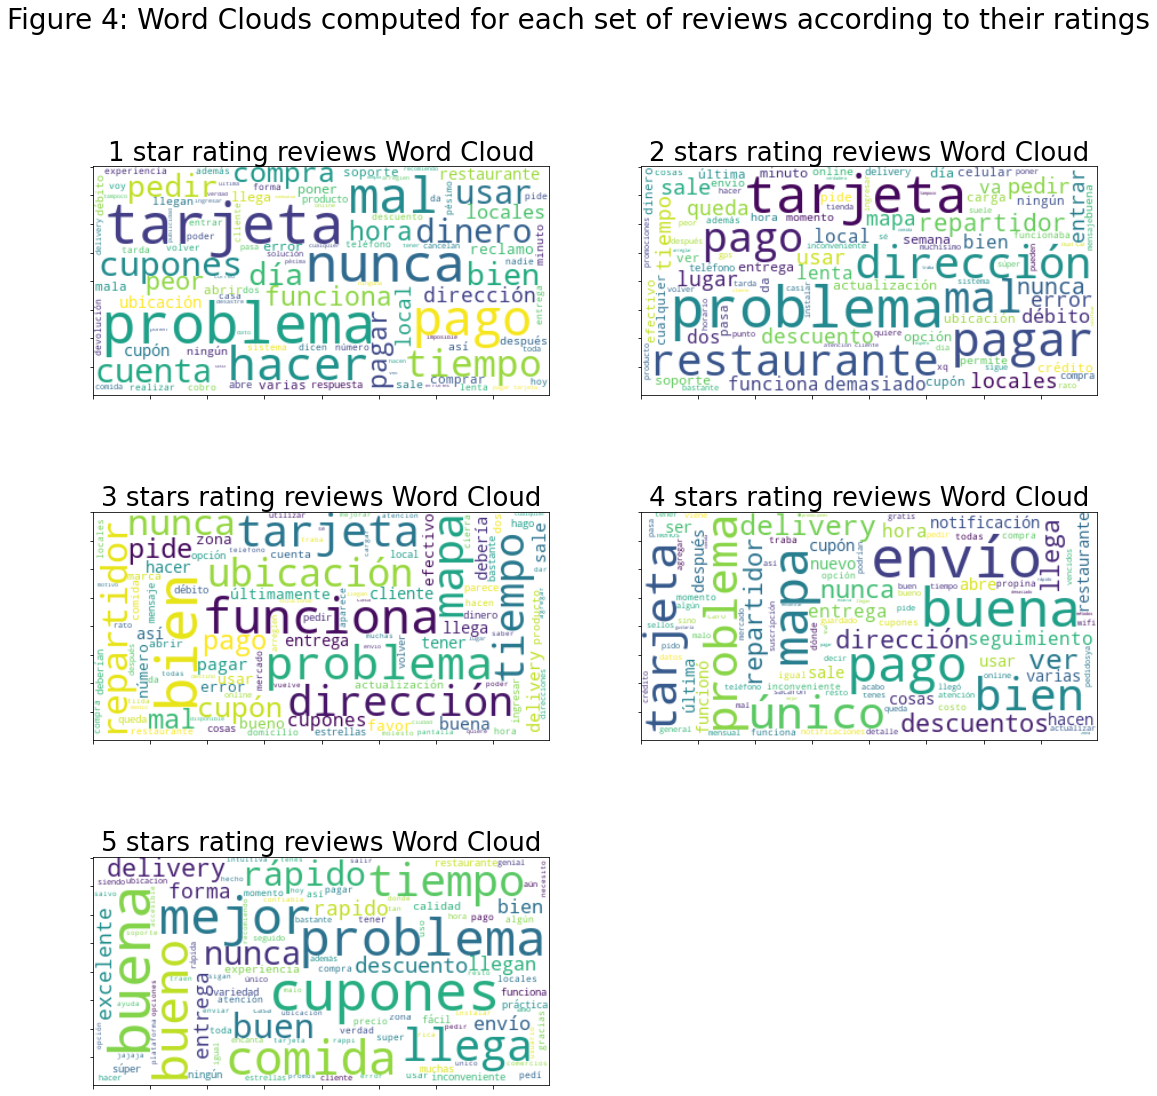

In [12]:
#@title `[Code]` Plot a bag of words for each set of reviews in the *PedidosYa* text corpus

#Stop Words are words that should not be included in further text analysis. In this case, the 
#words listed below have a very high frequency of occurence in the corpus and are ommited to 
#the purpose of mining other words with more meaning
stopwords = set(STOPWORDS)
stopwords.update(['app', 'aplicación', 'aplicacion', 'anda', 'cosa', 'solo', 'siempre', 'servicio',
                  'cada', 'dice', 'ahora', 'dan', 'hice', 'si', 'mas', 'vez', 'hace', 'quiero', 
                  'puedo', 'puede', 'luego', 'mucha', 'mucho', 'deja', 'mismo', 'misma', 'pedido', 'pedidos', 
                  'veces'])

#import matplotlib.gridspec as gridspec

wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, 
                      background_color='white')
f = plt.figure()
ax1 = plt.subplot2grid((3,2),(0, 0))
ax2 = plt.subplot2grid((3,2),(0, 1))
ax3 = plt.subplot2grid((3,2),(1, 0))
ax4 = plt.subplot2grid((3,2),(1, 1))
ax5 = plt.subplot2grid((3,2),(2, 0))
wordcloud.generate(''.join(review for review in cleanDF.loc[pyDF['score']==1, 0]))
ax1.imshow(wordcloud, interpolation='bilinear')
ax1.tick_params(labelbottom=False, labelleft=False)
ax1.set_title("1 star rating reviews Word Cloud", fontsize=26)
wordcloud.generate(''.join(review for review in cleanDF.loc[pyDF['score']==2, 0]))
ax2.imshow(wordcloud, interpolation='bilinear')
ax2.tick_params(labelbottom=False, labelleft=False)
ax2.set_title("2 stars rating reviews Word Cloud", fontsize=26)
wordcloud.generate(''.join(review for review in cleanDF.loc[pyDF['score']==3, 0]))
ax3.imshow(wordcloud, interpolation='bilinear')
ax3.tick_params(labelbottom=False, labelleft=False)
ax3.set_title("3 stars rating reviews Word Cloud", fontsize=26)
wordcloud.generate(''.join(review for review in cleanDF.loc[pyDF['score']==4, 0]))
ax4.imshow(wordcloud, interpolation='bilinear')
ax4.tick_params(labelbottom=False, labelleft=False)
ax4.set_title("4 stars rating reviews Word Cloud", fontsize=26)
wordcloud.generate(''.join(review for review in cleanDF.loc[pyDF['score']==5, 0]))
ax5.imshow(wordcloud, interpolation='bilinear')
ax5.tick_params(labelbottom=False, labelleft=False)
ax5.set_title("5 stars rating reviews Word Cloud", fontsize=26)
f.suptitle("Figure 4: Word Clouds computed for each set of reviews according to their ratings", fontsize=28)
f.set_figwidth(18)
f.set_figheight(18)


### <font color='Blue'>Insights:</font> The World Clouds give us an initial idea of the most frequent words used by the app users in their reviews. The bigger the font of the word, the higher the number of times that word appears in the text corpus. 
### By taking a closer look at the clouds for the one, two and three stars reviews, we can come with a list of frequent words that we can relate to the customers complain topics: tarjeta, cupones, repartidor, dirección, mapa, among others.
### Next, we proceed to identify those words with a more quantitative approach.  

### 1.5.2 Locating the top stem words and bigrams and computing their frequencies within the review texts according to the ratings

In [13]:
#@title `[Code]` Bar chart for the distribution of the top stem words found in the *PedidosYa* reviews text corpus
cols1 = pyVecDF1.columns[pyVecDF1.sum()>=50]
words = [word for word in cols1 if not word in stopwords]

ratings1 = pyVecDF1.loc[pyDF['score']==1, cols1].sum().to_list()
ratings2 = pyVecDF1.loc[pyDF['score']==2, cols1].sum().to_list()
ratings3 = pyVecDF1.loc[pyDF['score']==3, cols1].sum().to_list()
ratings4 = pyVecDF1.loc[pyDF['score']==4, cols1].sum().to_list()
ratings5 = pyVecDF1.loc[pyDF['score']==5, cols1].sum().to_list()

fig3 = go.Figure(data=[
    go.Bar(name='1 star', x=words, y=ratings1, marker_color=ratColors[0]),
    go.Bar(name='2 stars', x=words, y=ratings2, marker_color=ratColors[1]),
    go.Bar(name='3 stars', x=words, y=ratings3, marker_color=ratColors[2]),
    go.Bar(name='4 stars', x=words, y=ratings4, marker_color=ratColors[3]),
    go.Bar(name='5 stars', x=words, y=ratings5, marker_color=ratColors[4]),         
])

fig3.update_layout(barmode='stack', 
                  title='Figure 5: Distribution of top {} words according to Review ratings'.format(len(cols1)),
                  xaxis=dict(title='', titlefont_size=16, tickfont_size=11),
                  yaxis=dict(title='', titlefont_size=16, tickfont_size=11)
)
fig3.show()

In [14]:
#@title `[Code]` Bar chart for the distribution of the top bigrams found in the *PedidosYa* reviews text corpus
cols2 = pyVecDF2.columns[pyVecDF2.sum()>=10]
biGrams = cols2.to_list()

ratings1 = pyVecDF2.loc[pyDF['score']==1, cols2].sum().to_list()
ratings2 = pyVecDF2.loc[pyDF['score']==2, cols2].sum().to_list()
ratings3 = pyVecDF2.loc[pyDF['score']==3, cols2].sum().to_list()
ratings4 = pyVecDF2.loc[pyDF['score']==4, cols2].sum().to_list()
ratings5 = pyVecDF2.loc[pyDF['score']==5, cols2].sum().to_list()

fig3 = go.Figure(data=[
    go.Bar(name='1 star ratings', x=biGrams, y=ratings1, marker_color=ratColors[0]),
    go.Bar(name='2 stars ratings', x=biGrams, y=ratings2, marker_color=ratColors[1]),
    go.Bar(name='3 stars ratings', x=biGrams, y=ratings3, marker_color=ratColors[2]),
    go.Bar(name='4 stars ratings', x=biGrams, y=ratings4, marker_color=ratColors[3]),
    go.Bar(name='5 stars ratings', x=biGrams, y=ratings5, marker_color=ratColors[4]),         
])

fig3.update_layout(barmode='stack', 
                  title='Figure 6: Distribution of top {} bigrams according to Review ratings'.format(len(cols2)),
                  xaxis=dict(title='', titlefont_size=16, tickfont_size=11),
                  yaxis=dict(title='', titlefont_size=16, tickfont_size=11)
)
fig3.show()

### <font color='Blue'>Insights:</font> Analyzing the top bigrams from the reviews we can point out four main topics for the classification of the reviews:

- ### Payment related comments (*pago tarjeta*, *tarjeta credito*, *pago online*)
- ### Overall app functionality complains (*app funciona*, *cancela pedido*, *funciona mal*, *hacer pedido*, *ultima actualización*)
- ### Customer service (*atención cliente*)
- ### Coupon related issues (*usar cupon*, *dan cupon*)

### In addition to those topics, a look into the word clouds shows that the **location** of the clients is another major subject of complaint. 

_____

## 1.6 Exploratory Data Analysis: Measuring comunity engagement for the set of 1000 reviews


### 1.6.1 Computing the weekly and monthly number of reviews Thumbs Up to identify the reviews with the larger impact in the Google Play community  

In [15]:
#@title `[Code]` Compute weekly average ratings and the total number of Thumbs Up obtained during the given week

dates = pd.DataFrame([str(date).split(' ')[0].split('-') for date in pyDF['at']], columns=['Year', 'Month', 'Day'])
scores = []
dates_ = []
thumbsUp = []
topReviews = {}
weeks = {'1':['01', '02', '03', '04', '05', '06', '07'],
         '2':['08', '09', '10', '11', '12', '13', '14'],
         '3':['15', '16', '17', '18', '19', '20', '21'],
         '4':['22', '23', '24', '25', '26', '27', '28'],
         '5':['29', '30', '31']}
months = {'07':'Jul', '08':'Aug', '09':'Sep', '10':'Oct'}
for month in np.unique(dates['Month']):
  maxIndx = pyDF.loc[(dates['Month']==month), 'thumbsUpCount'].nlargest(n=1).index
  topReviews[month] = maxIndx
  for week in weeks:
    indx = (dates['Month']==month) & dates['Day'].isin(weeks[week])
    score = pyDF.loc[indx, 'score'].mean()
    scores.append(score if not np.isnan(score) else 0)
    thUp = pyDF.loc[indx, 'thumbsUpCount'].sum()
    thumbsUp.append(thUp if not np.isnan(thUp) else 0)
    dates_.append('-'.join([months[month], week]))

In [16]:
#@title `[Code]`Construct a scatter plot showing the total number of Thumbs up given to *PedidosYa* reviews in a weekly basis
fig6 = go.Figure()
fig6.add_trace(go.Scatter(
    x = dates_,y = thumbsUp,marker=dict(color=colors[4]),
    name="Thumbs up",
))

fig6.add_trace(go.Scatter(
    x = dates_,y = thumbsUp,marker=dict(color=colors[3], size=10),
    mode='markers', name="Thumbs up",   
))

fig6.update_layout(title="Figure 8: Weekly number of thumbs up given by Google Play users to written review entries",
                  xaxis_title="Period (Month-Week Number)",
                  yaxis_title="Thumbs up")
fig6.show()

In [17]:
#@title `[Code]` Construct a table containing the reviews with the higher number of Thumbs up in a monthly basis
table1 = go.Figure(data=[go.Table(
    #columnorder = [1,4],
    columnwidth = [80,400],
    header = dict(
        values=[['<b>Month</b>'], ['<b>Review Rating</b>'], ['<b>Thumbs Up</b>'], ['<b>Review content</b>']],
        line_color='darkslategray',
        fill_color=colors[0],
        align=['left'],
        font=dict(color='white', size=12),
        height=40  
    ),
    cells=dict(
        values=[list(months.values()), 
                [pyDF.loc[i[0], 'score'] for i in topReviews.values()],
                [pyDF.loc[i[0], 'thumbsUpCount'] for i in topReviews.values()],
                [pyDF.loc[i[0], 'content'] for i in topReviews.values()]
        ],
    )
)                     
])

table1.update_layout(title_text="Table 1: User reviews with the higher amount of Thumbs Up for each month from July to October")

# Section 2: Concluding Remarks

- ### **UberEats**, a close competitor to PedidosYa, displays a number of reviews from the Google Play community <font color='red'>13 times</font> the number of reviews of **PedidosYa**.
- ### A close analysis of the ratings for a sample set of 1000 reviews for **PedidosYa** shows that reviews with One, Two and Three stars account for over <font color='red'>70%</font> of the ratings. 
- ### Text analysis on the corpus conformed by the 1000 reviews shows that the topics of the reviews center around 5 main topics:

  - ### Payment issues.
  - ### App functionality.
  - ### Customer service.
  - ### Coupon related issues.
  - ### Locations. 

### <font color='blue'>What is next?</font>
The ground has being set for the deploiment of more complex Natural Language Processing tasks with the use of techniques as [Latent Dirichlent Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) or [Transformer](https://en.wikipedia.org/wiki/Transformer_(machine_learning_model)#:~:text=The%20Transformer%20is%20a%20deep,as%20translation%20and%20text%20summarization.) models for topic modeling. 

Further text analysis could be carried on the competitors reviews in Google Play to identify potential opportunities. 